# MRI reconstruction from multicoil data with given mask from test data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

# from facebook MRI
#import transforms
from data import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Notation

ksp for kspace,
np for numpy variable
tt for torch tensor

## Load MRI measurement

In [2]:
data_filename = './fastMRIdata/file1000190.h5' # default 2

f_data = h5py.File(data_filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f_data['kspace'].shape)
print("reconstruction_rss shape", f_data['reconstruction_rss'].shape)

# which slice to consider in the following
slicenu = 16
ksp_np = f_data['kspace'][slicenu]
ksp_tt = transform.to_tensor(ksp_np)      # Convert from numpy array to pytorch tensor

Kspace shape (number slices, number coils, x, y):  (36, 15, 640, 368)
reconstruction_rss shape (36, 320, 320)


## Load mask from a test image

mask shape: (640, 368)


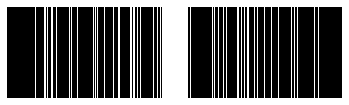

In [3]:
mask_filename = './fastMRIdata/file1001187_v2.h5' # 4x mask Test
f_mask = h5py.File(mask_filename, 'r')
mask = np.array(f_mask[list(f_mask.keys())[2]])

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask[:mask.shape[-1]//2-160] = 0 
mask[mask.shape[-1]//2+160:] =0
mask = np.repeat(mask[None,:], ksp_np.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask = np.pad(mask,((0,),((ksp_np.shape[-1]-mask.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up

print("mask shape:", mask.shape)

plt.imshow(mask[:100,:],cmap='gray')
plt.axis('off')
plt.show()

# Reconstruction with deep decoder from full measurement

### Define forward model

In [4]:
# the forward model - treats real and complex part of each slice as a separate channel
def forwardm(img,mask=mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

### Deep decoder setup

In [5]:
output_depth = ksp_np.shape[0]*2
out_size = ksp_np.shape[1:]

# depth and with specified here as num_channels = [width]*depth are tuning parameters
num_channels = [384]*10 
# in_size is also a tuning parameter
in_size = (16,16)

print("in_size", in_size)

net = deepdecoder( in_size,
                    out_size,
                output_depth,
                  num_channels=num_channels,
                need_sigmoid=False,
                #need_tanh=True,
                last_noup=True,
               ).type(dtype)
print(net)

in_size (16, 16)
[(24, 22), (34, 30), (49, 41), (70, 57), (102, 77), (147, 105), (212, 144), (307, 197), (443, 269), (640, 368)]
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(size=(24, 22), mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(size=(34, 30), mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(size=(49, 41), mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13):

In [6]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

### Scale ksp so that the scale of dd is right

In [7]:
### get norm of deep decoder output
# generate net input, scaling of that is irrelevant
shape = [1,num_channels[0], in_size[0], in_size[1]]
print("input shape: ", shape)
ni = Variable(torch.zeros(shape)).type(dtype)
ni.data.uniform_()
# generate random image
net(ni)
out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)
out_img_tt = transform.root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

# get norm of least-squares reconstruction
orig_tt = transform.ifft2(ksp_tt)           # Apply Inverse Fourier Transform to get the complex image
orig_imgs_tt = transform.complex_abs(orig_tt)   # Compute absolute value to get a real image
orig_img_tt = transform.root_sum_of_squares(orig_imgs_tt, dim=0)
orig_img_np = orig_img_tt.cpu().numpy()

scale_factor = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)

ksp_np = ksp_np*scale_factor # scale for deep decoder
ksp_tt = transform.to_tensor(ksp_np)      

input shape:  [1, 384, 16, 16]


### Least-squares reconstruction to monitor performance

In [8]:
orig_imgs_tt = transform.ifft2(ksp_tt)           # Apply Inverse Fourier Transform to get the complex image
orig_imgs_abs_tt = transform.complex_abs(orig_imgs_tt)   # Compute absolute value to get a real image
orig_img_tt = transform.root_sum_of_squares(orig_imgs_abs_tt, dim=0)
orig_img_np = orig_img_tt.cpu().numpy()

## get it in the shape for deep decoder loss function
out = []
for img in orig_imgs_tt:
    out += [ img[:,:,0].cpu().numpy() , img[:,:,1].cpu().numpy() ]
orig_imgs_dd_tt = torch.tensor(np.array([out]))

### Undersample and reconstruct

In [9]:
masked_ksp_np = np.array([ch for ch in ksp_np*mask[None,...]]) # applying the mask to every coil

# generate measurement
def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3, 0)) )

masked_ksp_tt = ksp2measurement( masked_ksp_np ).type(dtype)

### Fit deep decoder

In [10]:
mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0, 
                        num_iter=100000,
                        img_noisy_var=masked_ksp_tt,
                        LR = 0.0025, # 0.0025
                        #OPTIMIZER='SGD',
                        net=net,
                        apply_f = forwardm,
                        img_clean_var=Variable( orig_imgs_dd_tt ).type(dtype),
                        upsample_mode='free',
                        in_size = in_size,
                        find_best=True, # default is False
                        MRI_multicoil_reference=orig_img_np,
                        )

input shape:  [1, 384, 16, 16]
init norm:  1515.8436
orig img norm:  1499.6582
optimize with adam 0.0025


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



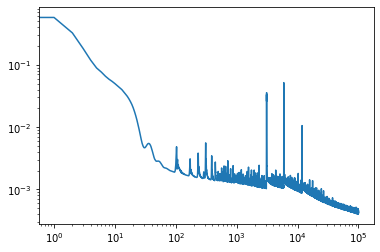

In [11]:
#plt.semilogx(mse_n)
plt.loglog(mse_n)

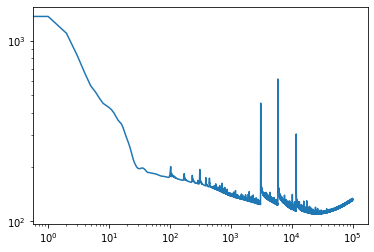

In [12]:
#plt.semilogx(mse_n)
plt.loglog(mse_t)

In [13]:
out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)
out_img_np = transform.root_sum_of_squares( torch.tensor(out_imgs) , dim=0).numpy()

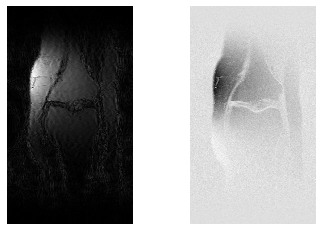

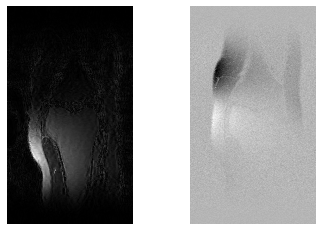

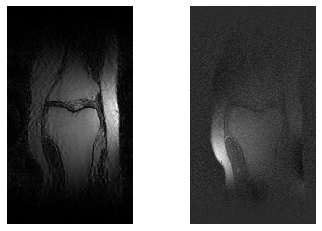

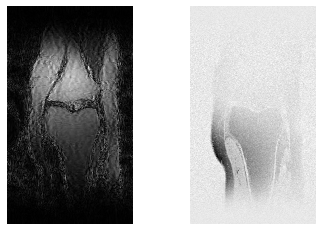

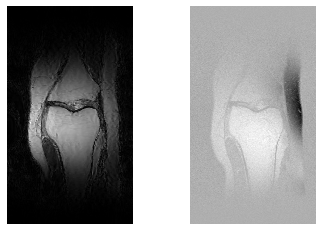

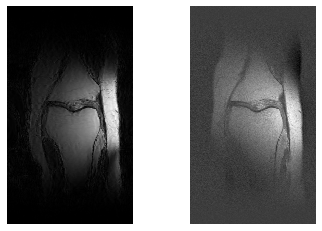

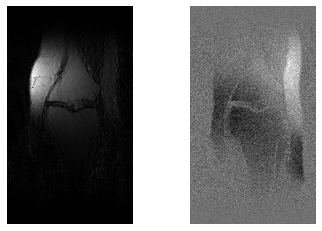

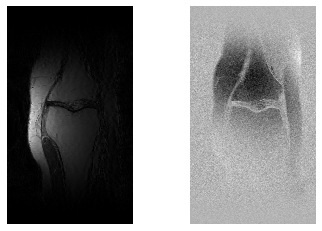

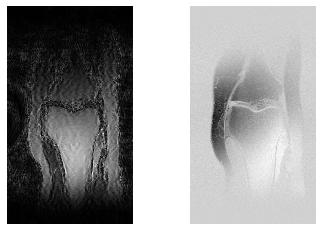

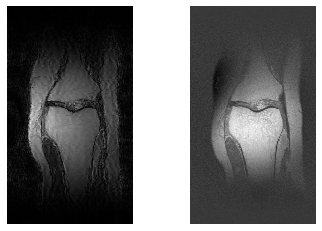

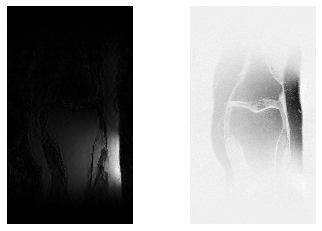

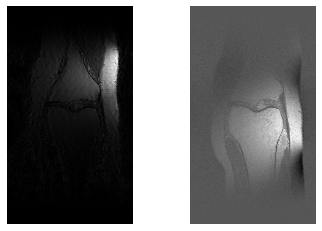

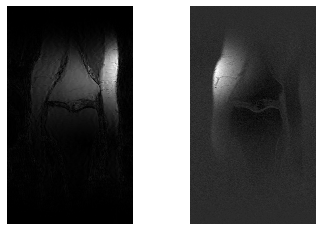

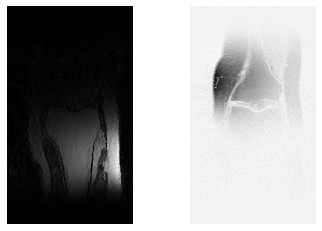

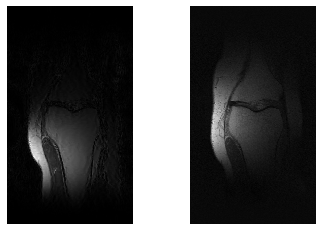

In [14]:
for img,imgorig in zip([img for img in out_imgs],[img for img in var_to_np( orig_imgs_dd_tt )]):
    fig = plt.figure() 
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img,cmap='gray')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(imgorig,cmap='gray')
    ax2.axis('off')
    fig.show()

### Least-squares reconstruction from masked kspace

In [15]:
masked_imgs_tt = transform.ifft2(masked_ksp_tt[0])           # Apply Inverse Fourier Transform to get the complex image
masked_imgs_abs_tt = transform.complex_abs(masked_imgs_tt)   # Compute absolute value to get a real image
masked_img_tt = transform.root_sum_of_squares(masked_imgs_abs_tt, dim=0)
masked_np = masked_img_tt.cpu().numpy()

### Plot results

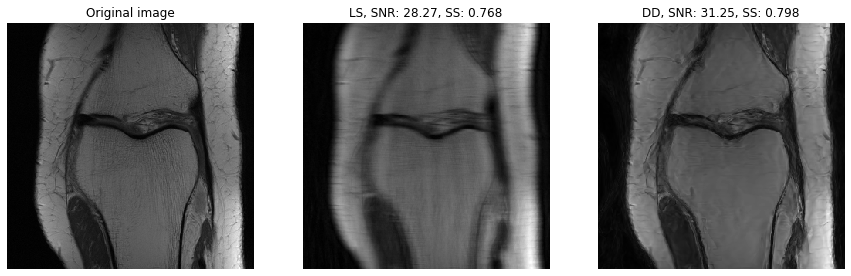

In [16]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

# least squares reconstruction
orig = crop_center( orig_img_np , 320,320)
# least squares reconstruction from masked kspace
masked = crop_center(masked_np,320,320)
# deep decoder reconstruction
rec = crop_center(out_img_np,320,320)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(masked,cmap='gray')
ax2.set_title( "LS, SNR: %.2f, SS: %.3f" % (psnr(orig,masked,np.max(orig)), ssim(orig, masked,data_range=orig.max())) ) 
ax2.axis('off')

ax3 = fig.add_subplot(133)
ax3.imshow(rec,cmap='gray')
ax3.set_title( "DD, SNR: %.2f, SS: %.3f" % (psnr(orig,rec,np.max(orig)), ssim(orig,rec,data_range=orig.max())) ) 
ax3.axis('off')  
    
plt.show()

In [17]:
def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=1000)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

R = np.vstack( (np.array([k for k in range(len(mse_n))]),mse_n,mse_t) ).T
savemtx_for_logplot( R.T, "CS_convergence_MRI.dat")